# Chi-Squared Test

Here, we generate samples of the chi-squared test statistic using i.i.d standard normal variates.

Based on the demonstration in an online forum [[link](https://stats.stackexchange.com/questions/16921/how-to-understand-degrees-of-freedom)]


In [1]:
%matplotlib inline
%load_ext cython

# Import requisite modules
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, chi2
from scipy.optimize import minimize


In [2]:
# Run parameters
seed = 22
numVariates = 20 # Number of i.i.d normal variates per repetition for the Chi-squared test
numRepetitions = 10000 # Number of repetitions of bin counts for the Chi-squared test

quantiles = [0.0, 0.25, 0.5, 0.75, 1.0] # Quantiles for binning the simulated data

In [3]:
# Intermediate quantities
bins = [norm.ppf(b) for b in quantiles]
numBins = len(np.diff(quantiles))


In [4]:
# Simulations
np.random.seed(seed) # Make simulation repeatable with seed parameter
data = np.random.normal(size=(numRepetitions, numVariates)) # Generate numRepetitions x numVariates i.i.d standard normals


In [5]:
#%%cython -a
#import numpy as np

# This function returns an array, with each entry being the chi-squared statistic computed for the 
def ComputeChiSquaredStatisicsNaive(data, bins):
    
    means = np.mean(data, axis=1) # For each repetition, determine the arithmetic mean of the variates
    stdvs = np.std(data, axis=1)  # For each repetition, determine the standard deviation of the variates
    
    # For each repetition, determine the expected count in each bin, according to the computed means and stdvs
    expected = np.diff(np.array([norm.cdf(b, loc=means, scale=stdvs) for b in bins]), axis=0).T * numVariates

    # For each repetition, determine the observed count in each bin from the simulation data
    observed = np.array([np.histogram(data[i], bins=bins)[0] for i in range(numRepetitions)])
    
    # For each repetition, compute the chi-squared statistic
    output = np.sum((observed - expected) ** 2 / expected, axis=1)
    
    return output
            


## Likelihood function for counts

The distribution of interest is the **normal** distribution:
$$X = \mathcal{N}(z|\mu, \sigma)$$

In our case, we have the four quartile intervals for the standard normal, $I_1=(-\infty, -0.67]$, $I_2=(-0.67, 0]$, $I_3=(0, +0.67]$ and $I_4=(+0.67, +\infty)$. With $
\theta=[\mu,\sigma]$, the probabilities in each case are $q_1(\theta) = \Phi\left( \dfrac{-0.67-\mu}{\sigma} \right)$, $q_2(\theta)=\Phi\left( \dfrac{0-\mu}{\sigma} \right)-\Phi\left( \dfrac{-0.67-\mu}{\sigma} \right)$, $q_3(\theta)=\Phi\left(\dfrac{+0.67-\mu}{\sigma} \right)-\Phi\left(\dfrac{0.0-\mu}{\sigma} \right)$ and $q_4(\theta)=1.0 - \Phi\left( \dfrac{+0.67-\mu}{\sigma} \right)$.

A single sample from $X$ falling into one of the four interval bins is a **categorical** random variable with probability $q_j$ for the $j^{th}$ category, $j \in 1,2,3,4$.

The distribution for $N$ samples is the distribution of a **sum** of $N$ i.i.d categorical variables. This is a **multinomial** distribution with parameters $N$ and $q_j, j \in 1,\ldots,4$. The likelihood function is then:

$$L(\mu, \sigma) = p\left([c_1,c_2,c_3,c_4]|N,\mu,\sigma\right)=\dfrac{n!}{c_1!c_2!c_3!c_4!} \prod_{j=1}^4 q_j(\mu, \sigma)^{x_j}$$

For convenience, we write the log-likelihood as:
$$f(\theta)\equiv f(\mu,\sigma) = \ln L(\mu, \sigma)=\text{constant} + \sum_{j=1}^4 c_j \ln q_j(\mu, \sigma)$$

The maximum likelihood, or **MLE**, parameters are given by:
$$\hat{\theta} = [\hat{\mu}, \hat{\sigma}] = \arg \max_{\theta} f(\theta)$$
This optimization may be carried out numerically.

In [6]:
# Define the relevant portion of the multinomial log-likelihood objective function

def MLEObjective(theta, counts):
    mu = theta[0]
    sd = theta[1]
    
    controlPoints = norm.cdf(bins, loc=mu, scale=sd) # CDF values at bin edges
    
    #print('bins=', end=''); print(bins) # DEBUG
    #print('controlPoints='); print(controlPoints) # DEBUG
    
    q = np.diff(controlPoints) # Probabilities of falling in each interval
    logq = np.log(q)
    
    #print('q=', end=''); print(q) # DEBUG
    #print('counts=', end=''); print(counts) # DEBUG
    
    val = -np.dot(logq, counts) # Portion of the log-likelihood that depends on parameters (negative for minimization)
    return val
    
def ComputeChiSquaredStatisticsMLE(data, bins):
    
    means = np.mean(data, axis=1) # For each repetition, determine the arithmetic mean of the variates
    stdvs = np.std(data, axis=1)  # For each repetition, determine the standard deviation of the variates

    # For each repetition, determine the observed count in each bin from the simulation data
    observed = np.array([np.histogram(data[i], bins=bins)[0] for i in range(numRepetitions)])
    
    # For each repetition, determine the expected count in each bin, according to the MLE parameters
    expected = np.zeros((numRepetitions, numBins))
    for i in range(numRepetitions):
        # Set up and solve for MLE parameters
        theta0 = np.array([0.0, 1.0]) # Initialize at standard normal params
        counts = observed[i]
        opt = minimize(MLEObjective, args=(counts), x0=theta0, bounds=[(None, None), (0.0, None)])
        thetaHat = opt.x
        muHat = thetaHat[0]
        sdHat = thetaHat[1]
        
        # print('In MLE function repetition {:5d}: muhat = {:+.7f}, sigmahat = {:+.7f}'.format(i, muHat, sdHat)) # DEBUG
        
        expected[i] = np.diff(np.array([norm.cdf(b, loc=muHat, scale=sdHat) for b in bins]), axis=0).T * numVariates
    
    # For each repetition, compute the chi-squared statistic
    output = np.sum((observed - expected) ** 2 / expected, axis=1)
    
    return output    
    


    

In [7]:
# Results of the chi-squared test based on simulations
chiSquaredResultsNaive = ComputeChiSquaredStatisicsNaive(data, bins)
chiSquaredResultsMLE = ComputeChiSquaredStatisticsMLE(data, bins)

# Overlay plots with theoretical PDFs for X^2(1) and X^2(2) plots
chiSquaredX = np.linspace(0.0, 20.0, 1000)
chiSquared1 = chi2.pdf(chiSquaredX, 1)
chiSquared2 = chi2.pdf(chiSquaredX, 2)

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: RuntimeWarning: divide by zero encountered in log
C:\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1732: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1732: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Anaconda3\lib\site-packages\scipy\stats\

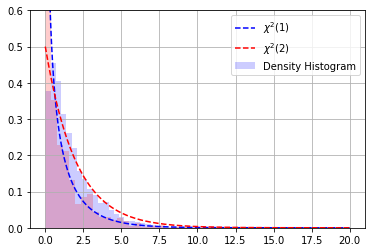

In [8]:
_, _, _ = plt.hist(chiSquaredResultsNaive, bins=50, density=True, fc=(0.0, 0.0, 1.0, 0.2))
_, _, _ = plt.hist(chiSquaredResultsMLE, bins=50, density=True, fc=(1.0, 0.0, 0.0, 0.2))
plt.plot(chiSquaredX, chiSquared1, 'b--')
plt.plot(chiSquaredX, chiSquared2, 'r--')
plt.ylim([0.0, 1.5])
plt.grid()
plt.legend(['$\chi^2(1)$', '$\chi^2(2)$', 'Density Histogram'])